In [1]:
from keras.applications import ResNet152
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from xgboost import XGBRegressor

import progressbar
import h5py
import numpy as np

## Generate Labels

In [8]:
f_train = open("lamem/splits/train_1.txt").readlines()
f_test = open("lamem/splits/test_1.txt").readlines()
f_val = open("lamem/splits/val_1.txt").readlines()

X_train_list = [x[:12] for x in f_train]
Y_train = np.array([float(x[13:21]) for x in f_train])

X_test_list = [x[:12] for x in f_test]
Y_test = np.array([float(x[13:21]) for x in f_test])

X_val_list = [x[:12] for x in f_val]
Y_val = np.array([float(x[13:21]) for x in f_val])

In [46]:
with h5py.File("Y.h5", "w") as h5f:
    for i in range(len(Y_train)):
        h5f.create_dataset(X_train_list[i], data=Y_train[i])
    for i in range(len(Y_test)):
        h5f.create_dataset(X_test_list[i], data=Y_test[i])
    for i in range(len(Y_val)):
        h5f.create_dataset(X_val_list[i], data=Y_val[i])

In [32]:
h5f = h5py.File("test_features.h5")

X_test_valide = [x in set(h5f.keys()) for x in X_test_list]
X_train_list = [x for x, y in zip(X_test_list, X_test_valide) if y]
Y_train = [x for x, y in zip(Y_test, X_test_valide) if y]

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


## Load dataset

In [24]:
# with h5py.File("train_features.h5") as h5f:
#     X_train = np.array([h5f[img][:] for img in X_train_list])
h5f_train = h5py.File("train_features.h5", "r")
h5f_test = h5py.File("test_features.h5", "r")
X  = np.array([h5f_train[img][:] for img in list(h5f_train.keys())] + [h5f_test[img][:] for img in list(h5f_test.keys())])
h5f2 = h5py.File("Y.h5", "r")
Y  = np.array([h5f2[img].value for img in list(h5f_train.keys())+list(h5f_test.keys())])

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys


In [25]:
print(X.shape, Y.shape)

(52757, 2048) (52757,)


In [26]:
train_set, test_set = train_test_split(range(len(X)), test_size=0.1)

## Prediction

### XGBoost regressor

In [31]:
def my_custom_loss_func(y_true, y_pred):
    c, p = spearmanr(y_true, y_pred)
    return c
score = make_scorer(my_custom_loss_func, greater_is_better=True)

In [34]:
ALGORITHMS = {
        'model': XGBRegressor(n_jobs=-1),
        'params': {
            "n_estimators": [100, 150, 200], # 'poly', 'sigmoid'
            "max_depth": [4, 5, 6],
            "eta": [0.01],
        }
    }
CV = 3
model = GridSearchCV(
        ALGORITHMS['model'],
        ALGORITHMS['params'],
        cv=CV,
        scoring=score,
        n_jobs=-1,
        )

In [35]:
model.fit(X[:7000], Y[:7000])

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constrain...
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             iid='warn', n_jobs=-

In [39]:
model = XGBRegressor(n_jobs=-1, n_estimators=200, max_depth=8, eta=0.01)
model.fit(X[:7000], Y[:7000])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00999999978, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [40]:
pred = model.predict(X[7000:])
c, p = spearmanr(Y[7000:], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.59634, p-value: 4.339106950756918e-74


### SVM

In [32]:
def my_custom_loss_func(y_true, y_pred):
    c, p = spearmanr(y_true, y_pred)
    return c
score = make_scorer(my_custom_loss_func, greater_is_better=True)

In [33]:
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV

ALGORITHMS = {
        'model': SVR(gamma='scale'),
        'params': {
            "kernel": ['rbf', 'sigmoid'], # 'poly', 'sigmoid'
            "C": [0.1, 1.0, 10.0],
            "epsilon": [0.001, 1.0],
        }
    }

CV = 3
model = GridSearchCV(
        ALGORITHMS['model'],
        ALGORITHMS['params'],
        cv=CV,
        scoring=score,
        n_jobs=-1,
        )

In [37]:
model = LinearSVR(C=1.0, epsilon=0.1)

In [38]:
model.fit(X[train_set], Y[train_set])

/Users/jojo/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=0.1, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

In [39]:
pred = model.predict(X[test_set])
c, p = spearmanr(Y[test_set], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.58618, p-value: 0.0


### Neural network

In [179]:
from keras.layers import *
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU
from keras.backend import expand_dims
from keras.losses import MeanSquaredLogarithmicError
import tensorflow as tf
from tensorflow.keras.losses import MSE

def correlation_loss(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return 2*MSE(x,y) - r_num / r_den

In [180]:
input_feature = Input(shape=(2048,), name='Input')
x = Dense(512, activation='relu')(input_feature)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [181]:
model = Model(input_feature, x)
model.compile(optimizer='adam', loss=correlation_loss)

In [182]:
model.fit(X[train_set], Y[train_set], batch_size=256, epochs=10, validation_data=(X[test_set], Y[test_set]))

Epoch 1/10
186/186 [==============================] - 2s 9ms/step - loss: -0.4153 - val_loss: -0.6119
Epoch 2/10
186/186 [==============================] - 2s 8ms/step - loss: -0.5868 - val_loss: -0.6335
Epoch 3/10
186/186 [==============================] - 2s 10ms/step - loss: -0.6162 - val_loss: -0.6373
Epoch 4/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6346 - val_loss: -0.6415
Epoch 5/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6473 - val_loss: -0.6485
Epoch 6/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6549 - val_loss: -0.6472
Epoch 7/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6641 - val_loss: -0.6484
Epoch 8/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6694 - val_loss: -0.6498
Epoch 9/10
186/186 [==============================] - 2s 9ms/step - loss: -0.6806 - val_loss: -0.6524
Epoch 10/10
186/186 [==============================] - 2s 9ms/step - loss: -0.684

In [183]:
pred = model.predict(X[test_set])
c, p = spearmanr(Y[test_set], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.67365, p-value: 0.0


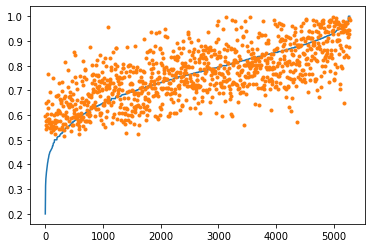

In [184]:
import matplotlib.pyplot as plt

c = list(range(0, len(Y[test_set]), 5))
index = np.argsort(Y[test_set])[c]
Y_pred = model.predict(X[test_set])

plt.plot(c, Y[test_set][index])
plt.plot(c, Y_pred[index], '.')

## Nomalized label

In [148]:
# Y_new = (Y-np.mean(Y))/np.std(Y)
Y_new = np.clip((Y-np.mean(Y))/np.std(Y), -1.0, 1.0)
# Y_new = (Y-np.min(Y))/(np.max(Y)-np.min(Y))

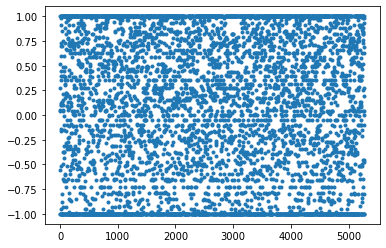

In [149]:
plt.plot(Y_new[test_set], ".")

In [210]:
def correlation_loss(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return 1*MSE(x,y) - r_num / r_den

In [216]:
activation = "tanh"

input_feature = Input(shape=(2048,), name='Input')
x = Dense(512, activation="relu")(input_feature)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(1, activation=activation)(x)

In [217]:
model = Model(input_feature, x)
model.compile(optimizer='adam', loss="mse")

In [221]:
model.fit(X[train_set], Y_new[train_set], batch_size=256, epochs=10, validation_data=(X[test_set], Y_new[test_set]))

Epoch 1/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2721 - val_loss: 0.2988
Epoch 2/10
186/186 [==============================] - 2s 10ms/step - loss: 0.2691 - val_loss: 0.3050
Epoch 3/10
186/186 [==============================] - 2s 10ms/step - loss: 0.2620 - val_loss: 0.2964
Epoch 4/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2589 - val_loss: 0.2956
Epoch 5/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2519 - val_loss: 0.2991
Epoch 6/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2480 - val_loss: 0.2999
Epoch 7/10
186/186 [==============================] - 2s 12ms/step - loss: 0.2422 - val_loss: 0.2995
Epoch 8/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2388 - val_loss: 0.3060
Epoch 9/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2325 - val_loss: 0.2994
Epoch 10/10
186/186 [==============================] - 2s 11ms/step - loss: 0.2275 - val_lo

In [222]:
pred = model.predict(X[test_set])
c, p = spearmanr(Y_new[test_set], pred)

print("Spearmanr Result: correlation: {:.5f}, p-value: {}".format(c, p))

Spearmanr Result: correlation: 0.66387, p-value: 0.0


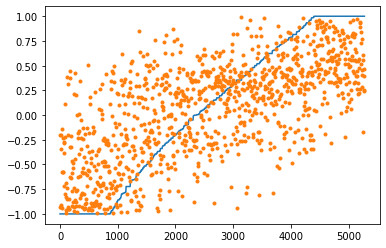

In [223]:
import matplotlib.pyplot as plt

c = list(range(0, len(Y_new[test_set]), 5))
index = np.argsort(Y_new[test_set])[c]
Y_new_pred = model.predict(X[test_set])
plt.plot(c, Y_new[test_set][index])
plt.plot(c, Y_new_pred[index], '.')

In [128]:
np.sum(Y_new[test_set]>1)

871

In [135]:
np.sum(Y_pred[Y[test_set]>0.5]>0.5) / np.sum(Y[test_set]>0.5)

0.9960560047327943

In [194]:
IMG_SIZE=(224, 224)
image = load_img("frame/dyson1.mp4-frame-200.jpg", target_size=IMG_SIZE)
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
features = ResNet152(weights="imagenet", include_top=False, pooling='avg').predict(image)

In [195]:
model.predict(features)

array([[0.582735]], dtype=float32)